In [1]:
import os # For finding source files
from pathlib import Path

import pandas as pd # For data handling

In [2]:
DirPpath = Path(os.path.abspath('')).parent # Fetching the current directory path's parent
CSVFilePath = str(DirPpath.absolute()) + "\OutputFiles\CleanedData.csv"  

print("Current Location of the Data file is :", CSVFilePath)

PledgeDf = pd.read_csv(CSVFilePath, index_col=0) # Creating a dataframe from the content of the csv file # Args: index_col = 0, first column of the csv contains the indexes

# Inspecting the first rows of the dataframe
PledgeDf.head()


Current Location of the Data file is : c:\Users\ecaudron001\Documents\GitHub\semic_pledges\OutputFiles\CleanedData.csv


,Topic,Pledge
0,1,Actually we as an association are still pretty...
1,1,EFFAT welcomes the Commission Proposal for a R...
2,1,HOTREC calls for a level playing field and fai...
3,1,Estonia sees the need to synchronize and harmo...
4,1,Sphere Travel Club contributes to a flourishin...


# NER with spacy

## Small preprocessing

In [3]:
import string
import re
import contractions

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

def first_clean(text):
    return " ".join(text.split())

def RemoveURL(text):
    """Remove URLs from a sample string"""
    text = re.sub(r"https:\s?\S+", "", text)
    text = re.sub(r"http\S+", "", text) 
    #text = text.replace("-", " ")
    #text = text.replace("/", " ")
    return re.sub(r'[^\x00-\x7f]',r'',  text) # Remove non-ASCII

PledgeDf["PreProcessedText"] = PledgeDf["Pledge"].apply(lambda x: RemoveURL(first_clean(x)))


## Sentence tokenization

In [4]:
import spacy
from spacy import displacy

In [5]:
nlp = spacy.load("en_core_web_sm")

SentTokens = [[sent.text for sent in nlp(doc).sents] for doc in PledgeDf["PreProcessedText"]]

## Filter on Date

In [6]:
from word2number import w2n
from calendar import month_name
from datetime import datetime

def NERDates(doc, datelim):

    # 1° NER Dates
    datesPattern = re.compile(r'(\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3})')
    dates = set((ent.text) for ent in doc.ents if ent.label_ == "DATE" and ((re.search(r"[12][0-9]{3}", ent.text) and int(re.findall(r"[12][0-9]{3}", ent.text)[0]) > datelim) or (re.search(r"^(-within|up to)", ent.text)))) #Limit ourself to expression with years > 2022
    filteredDates = set(date for date in dates if not datesPattern.match(date))

    return filteredDates

def ExceptionDates(doc, filteredDates, datelim):

    # 2° Exceptions 1 --> Dates intervals using regex
    exceptions = re.findall(r"[12][0-9]{3}\-[12][0-9]{3}|[12][0-9]{3}\/[12][0-9]{3}", doc.text)

    for exception in exceptions:
        if int(re.findall(r"[12][0-9]{3}$", exception)[0]) > datelim:
            filteredDates.add(str(re.findall(r"[12][0-9]{3}$", exception)[0])) # Use the end of interval for this sentence

    # 3° Exceptions 2 --> Specific structures using regex
    exceptions = re.findall(r"(by 2025 data|up to 2027 are:|Target: 2023|the project - 2023|end of 2023 NBTC|a framework Q2 2023)", doc.text)
    #print(exceptions)
    for exception in exceptions:
        if int(re.findall(r"[12][0-9]{3}", exception)[0]) > datelim:
            filteredDates.add(exception)


def ExtractYears(filteredDates):

    years = set()
    # To change season, quarter, etc. to month expressions
    mapDict = {"Summer": "August", "summer": "August", "Fall": "November", "fall": "November", "Winter": "February", "winter": "February", "Spring": "June", "spring": "June", "the Summer of": "August", "summer of": "August", "Fall of": "November", "fall of": "November", "Winter of": "February", "winter of": "February", "Spring of": "June", "spring of": "June", "Q1": "March", "Q2": "June", "Q3": "September", "Q4": "December", "early": "January", "the end of": "December", "First half of": "June", "first half of": "June", "Second half of": "December", "second half of": "December", "1st semester of": "June", "2nd semester of": "December", "1st quarter of": "March", "2nd quarter": "June", "3rd quarter": "September", "4th quarter": "December"}

    for date in filteredDates:

        try:
            pattern = '|'.join(list(mapDict.keys()))
            date = re.sub(pattern, mapDict[re.search(pattern, date).group(0)], date)
        except:
            print("")
        
        try:
            pattern = 'January [12][0-9]{3}|February [12][0-9]{3}|March [12][0-9]{3}|April [12][0-9]{3}|May [12][0-9]{3}|June [12][0-9]{3}|July [12][0-9]{3}|August [12][0-9]{3}|September [12][0-9]{3}|October [12][0-9]{3}|November [12][0-9]{3}|December [12][0-9]{3}'
            year = re.findall(pattern, date, re.IGNORECASE)[0]

        except:
            try:
                year = "January " + str(re.findall(r"[12][0-9]{3}", date)[0])
            except:
                try:
                    gap = w2n.word_to_num(date)
                    year = "January " + str(2023 + gap)
                except:
                    gap = int(re.findall(r'\d+', date)[0])
                    year = "January " + str(2023 + gap)

        year = datetime.strptime(year, '%B %Y')

        years.add(year)
    
    print(years)    
    print("\n")
    return years

            

In [ ]:
n = 0
n2 = 0
n3 = 0
for Pledge, topic, cluster in zip(SentTokens, PledgeDf2["Topics"], PledgeDf2["Cluster"]):

    datesPresent = 0

    for sent in Pledge:

        doc = nlp(sent)

        filteredDates = NERDates(doc, 2022)
        if filteredDates != set():
            print(filteredDates)

            for date in filteredDates:
                n+=1
                try:
                    x = re.findall(r"[12][0-9]{3}", date)[0]
                    n2 +=1

                except:
                    print("0")


In [86]:
print(n)
print(n2)
print(n2/n)

455
451
0.9912087912087912


In [153]:
type(doc)

spacy.tokens.doc.Doc

In [ ]:
n3 = 0
for Pledge, topic, cluster in zip(SentTokens, PledgeDf2["Topics"], PledgeDf2["Cluster"]):

    datesPresent = 0

    for sent in Pledge:

        doc = nlp(sent)

        filteredDates = NERDates(doc, 2022)
        ExceptionDates(doc, filteredDates, 2022)
        if filteredDates != set():
            print(filteredDates)

            for date in filteredDates:
                n3+=1

In [89]:
n3-n

53

In [8]:
DirPpath = Path(os.path.abspath('')).parent # Fetching the current directory path's parent
CSVFilePath = str(DirPpath.absolute()) + "\OutputFiles\Clusters.xlsx"  

print("Current Location of the Data file is :", CSVFilePath)

PledgeDf2 = pd.read_excel(CSVFilePath) # Creating a dataframe from the content of the csv file # Args: index_col = 0, first column of the csv contains the indexes

# Inspecting the first rows of the dataframe
PledgeDf2.head()

Current Location of the Data file is : c:\Users\ecaudron001\Documents\GitHub\semic_pledges\OutputFiles\Clusters.xlsx


,Unnamed: 0,Pledge,PreProcessedText,Cluster,Topics,Area
0,0,Actually we as an association are still pretty...,actually association still pretty much begin d...,5,1,Policy & regulation
1,1,EFFAT welcomes the Commission Proposal for a R...,effat welcome commission proposal regulation d...,5,1,Policy & regulation
2,2,HOTREC calls for a level playing field and fai...,hotrec call level play field fair competition ...,4,1,Policy & regulation
3,3,Estonia sees the need to synchronize and harmo...,estonia see need synchronize harmonize rule sh...,5,1,Policy & regulation
4,4,Sphere Travel Club contributes to a flourishin...,sphere travel club contribute flourish transpa...,5,1,Policy & regulation


In [9]:
# For each sentence look for dates > 2022 and in numerical format

MultDatesSent = []
DatesSent = []
DatesPledge = []
topics = []
clusters = []
Dates = []
Pledges = []

for Pledge, topic, cluster in zip(SentTokens, PledgeDf2["Topics"], PledgeDf2["Cluster"]):

    datesPresent = 0

    for sent in Pledge:

        doc = nlp(sent)

        filteredDates = NERDates(doc, 2022)
        ExceptionDates(doc, filteredDates, 2022)
        
        # Resultats
        if filteredDates != set():
            print(filteredDates)

            #print(filteredDates)
            datesPresent = 1
            years = ExtractYears(filteredDates)
            #print(years)

            if len(years)> 1:
                MultDatesSent.append(sent)
                for date in years:
                    #print(sent)
                    Dates.append(date)
                    # ADD A FUNCTION TO SPLIT SENTENCE INTO CLAUSES CONTAINING THE DATES
                    DatesSent.append(sent)
                    topics.append(topic)
                    clusters.append(cluster)
                    Pledges.append(" ".join(Pledge))
            else:
                Dates.append(list(years)[0])
                DatesSent.append(sent)
                topics.append(topic)
                clusters.append(cluster) 
                Pledges.append(" ".join(Pledge))
            
    
    #print(datesPresent)
    DatesPledge.append(datesPresent)

{'2025'}

{datetime.datetime(2025, 1, 1, 0, 0)}


{'2024', '2025'}


{datetime.datetime(2024, 1, 1, 0, 0), datetime.datetime(2025, 1, 1, 0, 0)}


{'2025'}

{datetime.datetime(2025, 1, 1, 0, 0)}


{'2025'}

{datetime.datetime(2025, 1, 1, 0, 0)}


{'2023'}

{datetime.datetime(2023, 1, 1, 0, 0)}


{'the end of 2023'}
{datetime.datetime(2023, 12, 1, 0, 0)}


{'2024'}

{datetime.datetime(2024, 1, 1, 0, 0)}


{'2025'}

{datetime.datetime(2025, 1, 1, 0, 0)}


{'the end of 2024', 'the end of 2023'}
{datetime.datetime(2023, 12, 1, 0, 0), datetime.datetime(2024, 12, 1, 0, 0)}


{'2023'}

{datetime.datetime(2023, 1, 1, 0, 0)}


{'2025'}

{datetime.datetime(2025, 1, 1, 0, 0)}


{'2025'}

{datetime.datetime(2025, 1, 1, 0, 0)}


{'2030'}

{datetime.datetime(2030, 1, 1, 0, 0)}


{'2025'}

{datetime.datetime(2025, 1, 1, 0, 0)}


{'2025'}

{datetime.datetime(2025, 1, 1, 0, 0)}


{'2027'}

{datetime.datetime(2027, 1, 1, 0, 0)}


{'2025'}

{datetime.datetime(2025, 1, 1, 0, 0)}


{'December 2023', 'spring

## First analysis

Date
1       308
0        65
dtype: int64


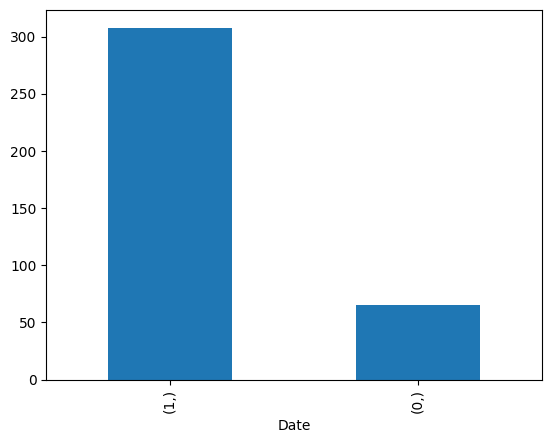

In [99]:
# Pledge containing a Date
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.DataFrame(DatesPledge, columns=["Date"])

data.value_counts().plot(kind="bar")
print(data.value_counts())

In [101]:
len(DatesSent) - len(MultDatesSent)

458

In [123]:
len(DatesSent)

507

In [10]:
DatesResults2 = pd.DataFrame({"Pledge": Pledges, "Sentences": DatesSent, "Dates": Dates, "Topics": topics, "Clusters": clusters})
DatesResults2.head()

,Pledge,Sentences,Dates,Topics,Clusters
0,Actually we as an association are still pretty...,Our target for 2025 is to achieve that guideline.,2025-01-01 00:00:00,1,5
1,EFFAT welcomes the Commission Proposal for a R...,"EFFAT will - in 2023-2024, follow the legislat...",2024-01-01 00:00:00,1,5
2,EFFAT welcomes the Commission Proposal for a R...,"EFFAT will - in 2023-2024, follow the legislat...",2025-01-01 00:00:00,1,5
3,Sphere Travel Club contributes to a flourishin...,Our target for 2025 is to have at least 15 pro...,2025-01-01 00:00:00,1,5
4,Sphere Travel Club contributes to a flourishin...,Our target for 2025 is to have saved 10.000 we...,2025-01-01 00:00:00,1,5


## Extracting results

In [27]:
ResultsNouns = ["goal", "goals", "target", "targets", "objective", "objectives", "results", "result", "aim", "aims", "measures", "milestones"]

def FirstClean(text): #Input - String or text you want to process
    return " ".join(text.split()).replace("_x000D_","") #Output - Same string without \n and _x000D_

def ReplaceContractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def PreProcess(text): #Input - String or text you want to process
    text = re.sub(r"https:\s?\S+", "", text)
    text = re.sub(r"http\S+", "", text) # Remove urls
    text = text.lower() # Lowercase all the characters from the string
    text = text.strip() # Remove the leading and trailing whitespaces
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text) # Removing Punctuation
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.sub(r'[^\w\s]', '', str(text)) # Remove non alphanumeric characters
    text = re.sub(r'\d', '', text) # Removing digits
    text = re.sub(r"\b[a-zA-Z]\b", "", text) # Removing single characters
    text = re.sub(r'\s+', ' ', str(text).strip()) # Replacing "double, triple, etc" whitespaces by one
    return text #Output - Same string after all the transformations

def StopWord(string): #Input - String or text to process
    a = [i for i in string.split() if i not in stopwords.words('english') and i not in ResultsNouns] # Removing usual english stopwords from the string
    return a #Output - Same string after all the transformations

def GetResultsNouns(DatesSent):
    # List of typical phrases announcing a results
    ResultsPatterns = "goal|goals|target|targets|objective|objectives|result|results|aim|aims to have by|increases by|decreases by|we expect to|expected for|are expected to|for [12][0-9]{3}|expect that by|as of [12][0-9]{3}|in [12][0-9]{3}|for [12][0-9]{3}|by [12][0-9]{3}|expected by|aimed at|our target for [12][0-9]{3} is to have|should be online|should be ready|from [12][0-9]{3}|measurable|milestones|report|Report|reports|Reports|event|events|Event|Events|conference|conferences|Conference|Conferences|webinar|webinars|Webinar|Webinars|training|trainings|Training|Trainings|course|courses|Course|Courses|project result|project results|Project result|Project results|Fact sheet|Fact sheets|fact sheet|fact sheets|Best practice|Best practices|best practice|best practices|best practice collecion|Best practice collection|best practices collection|Best practices collection|newsletters|newsletter|Newsletter|Newsletters"
    
    # List of results categories and their typical phrases
    ReportPattern = "report|Report|reports|Reports|study|Study|studies|Studies|reporting|Reporting"
    EventPattern =   "event|events|Event|Events|conference|conferences|Conference|Conferences|webinar|webinars|Webinar|Webinars"
    TrainingPattern = "training|trainings|Training|Trainings|course|courses|Course|Courses"
    ProjectPattern = "project result|project results|Project result|Project results|Fact sheet|Fact sheets|fact sheet|fact sheets"
    PracticePattern = "Best practice|Best practices|best practice|best practices|best practice collecion|Best practice collection|best practices collection|Best practices collection|newsletters|newsletter|Newsletter|Newsletters"
    AwardPattern = "award|Award|awards|Awards|certification|Certification|Certifications|certifications|label|Label|labels|Labels"
    
    ResultsSent = []
    #ResultsChunks = []
    ResultsNouns = []
    Results = []

    Report = []
    Event = []
    Training = []
    Project = []
    Practice = []
    Award = []

    for sent in DatesSent:
        try: 
            # Identify results sentences
            re.findall(ResultsPatterns, sent, re.IGNORECASE)[0]
            ResultsSent.append(1)
            Results.append(sent)

            if re.search(ReportPattern, sent, re.IGNORECASE):
                Report.append(1)
            else: 
                Report.append(0)
            
            if re.search(EventPattern, sent, re.IGNORECASE):
                Event.append(1)
            else:
                Event.append(0)

            if re.search(TrainingPattern, sent, re.IGNORECASE):
                Training.append(1)
            else:
                Training.append(0)

            if re.search(ProjectPattern, sent, re.IGNORECASE):
                Project.append(1)
            else:
                Project.append(0)

            if re.search(PracticePattern, sent, re.IGNORECASE):
                Practice.append(1)
            else:
                Practice.append(0)

            if re.search(AwardPattern, sent, re.IGNORECASE):
                Award.append(1)
            else:
                Award.append(0)

            # Chunking

            sampleSentence = nltk.word_tokenize(sent)
            sampleSentencePOS = nltk.pos_tag(sampleSentence)
            
            # Find Nouns or proper Nouns
            OnlyNouns = (" ").join([POStags[0] for POStags in sampleSentencePOS if POStags[1] in ['NN','NNP']])

            # Remove stopwords and patterns
            sent = OnlyNouns.lower()
            sent = StopWord(PreProcess(ReplaceContractions(FirstClean(sent))))

            ResultsNouns.extend(sent)


        except:

            ResultsSent.append(0)
            Report.append(0)
            Event.append(0)
            Training.append(0)
            Project.append(0)
            Practice.append(0)
            Award.append(0)
            
    return ResultsSent, Report, Event, Training, Project, Practice, Award, ResultsNouns, Results


In [127]:
# List of results words per dates
x = DatesResults2.groupby(DatesResults2["Dates"]).apply(lambda x: GetResultsNouns(x["Sentences"])[1])

In [128]:
print(x)

Dates
2023-01-01 00:00:00    [cna, turismo, commercio, period, autumn, trai...
2023-02-01 00:00:00                                                   []
2023-03-01 00:00:00     [number, process, march, number, process, march]
2023-04-01 00:00:00                                                   []
2023-05-01 00:00:00                                                   []
2023-06-01 00:00:00    [dg, reform, support, service, support, oecd, ...
2023-07-01 00:00:00    [work, july, july, revitalisation, eu, strateg...
2023-08-01 00:00:00    [sake, publish, august, inhouse, strategy, hau...
2023-09-01 00:00:00    [key, june, incorporate, sustainable, digital,...
2023-11-01 00:00:00                                                   []
2023-12-01 00:00:00    [phase, end, data, end, library, dg, reform, s...
2024-01-01 00:00:00    [effat, procedure, regulation, european, parli...
2024-03-01 00:00:00                                                   []
2024-05-01 00:00:00                          

In [129]:
# List of sentence with result per date
y = DatesResults2.groupby(DatesResults2["Dates"]).apply(lambda x: GetResultsNouns(x["Sentences"])[2])

In [130]:
print(y)

Dates
2023-01-01 00:00:00    [CNA Turismo e Commercio, over the three-year ...
2023-02-01 00:00:00                                                   []
2023-03-01 00:00:00    [Eur The target number of companies should be ...
2023-04-01 00:00:00                                                   []
2023-05-01 00:00:00                                                   []
2023-06-01 00:00:00    [This DG Reform Support Service, implemented w...
2023-07-01 00:00:00    [The work has started in July 2022 and the fir...
2023-08-01 00:00:00    [For the sake of implementing this objective w...
2023-09-01 00:00:00    [Key Milestones - June 2023 - Incorporate Sust...
2023-11-01 00:00:00                                                   []
2023-12-01 00:00:00    [Target: the first phase should be online by t...
2024-01-01 00:00:00    [EFFAT will - in 2023-2024, follow the legisla...
2024-03-01 00:00:00                                                   []
2024-05-01 00:00:00                          

In [23]:
len(output[7])

3442

In [28]:
output = GetResultsNouns(DatesResults2["Sentences"])

names = ["Results?", "Reports?", "Events?", "Trainings?", "Project results", "Best practices?", "Awards?"]

i = 0

for name in names:

    DatesResults2[name] =  output[i]
    i +=1

In [29]:
DatesResults2.head()

,Pledge,Sentences,Dates,Topics,Clusters,Results?,Reports?,Events?,Trainings?,Project results,Best practices?,Awards?
0,Actually we as an association are still pretty...,Our target for 2025 is to achieve that guideline.,2025-01-01 00:00:00,1,5,1,0,0,0,0,0,0
1,EFFAT welcomes the Commission Proposal for a R...,"EFFAT will - in 2023-2024, follow the legislat...",2024-01-01 00:00:00,1,5,1,1,0,0,0,0,0
2,EFFAT welcomes the Commission Proposal for a R...,"EFFAT will - in 2023-2024, follow the legislat...",2025-01-01 00:00:00,1,5,1,1,0,0,0,0,0
3,Sphere Travel Club contributes to a flourishin...,Our target for 2025 is to have at least 15 pro...,2025-01-01 00:00:00,1,5,1,0,0,0,0,0,0
4,Sphere Travel Club contributes to a flourishin...,Our target for 2025 is to have saved 10.000 we...,2025-01-01 00:00:00,1,5,1,0,0,0,0,0,0


In [30]:
# Excel format
DatesResults2.to_excel("NER4.xlsx")

## First Analysis

256


C:\Users\ecaudron001\AppData\Local\Temp\ipykernel_5960\4015895145.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pledgeplot = pd.Series([1]).repeat(256).append(pd.Series([0]).repeat(373-256))


<Axes: >

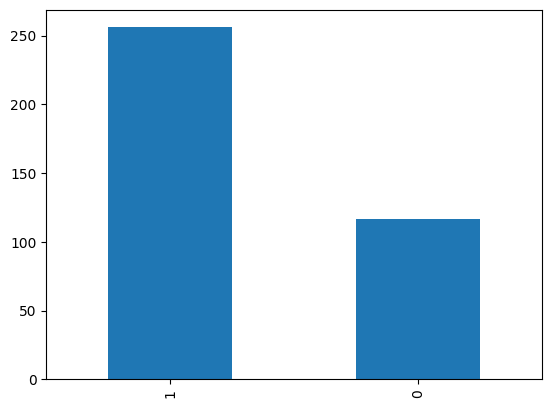

In [141]:
firstAnalysis = DatesResults2[DatesResults2["Results?"] == 1]

print(firstAnalysis["Pledge"].value_counts().size)

pledgeplot = pd.Series([1]).repeat(256).append(pd.Series([0]).repeat(373-256))
pledgeplot.value_counts().plot(kind="bar")

1    389
0    118
Name: Results?, dtype: int64


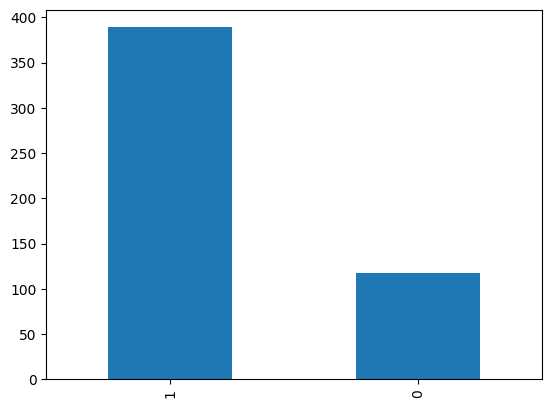

In [113]:
# Timeline for a specific time frame, only results sentences

import matplotlib.pyplot as plt

data = DatesResults2.copy()
data["Results?"].value_counts().plot(kind="bar")
print(data["Results?"].value_counts())

## TimeLine of results

(0.0, 150.0)

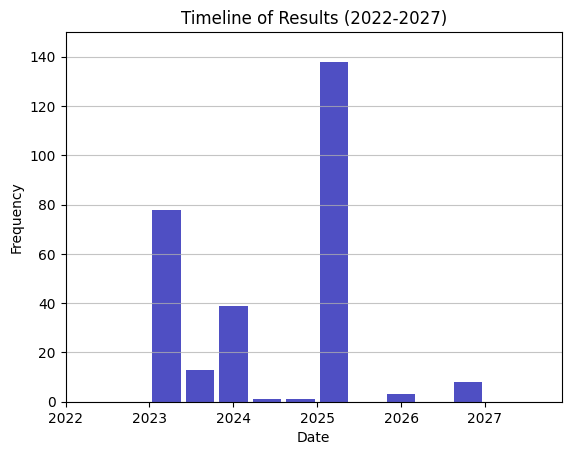

In [145]:
# Timeline for a specific time frame, only results sentences

import matplotlib.pyplot as plt
import numpy as np

dateMin = datetime.strptime("January 2022", '%B %Y')
dateMax = datetime.strptime("December 2027", '%B %Y')

data = DatesResults2[(DatesResults2["Dates"] >= dateMin) & (DatesResults2["Dates"] <= dateMax) & (DatesResults2["Results?"] == 1)]

# plt.hist(data["Dates"])
# plt.ylim(ymax = 140)

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=data["Dates"], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Timeline of Results (2022-2027)')
#plt.xticks(rotation = 45, ha = 'right')
# Set a clean upper y-axis limit.
plt.ylim(ymax=30)
plt.xlim([dateMin, dateMax])
# Set a clean upper y-axis limit.
plt.ylim(ymax=150)

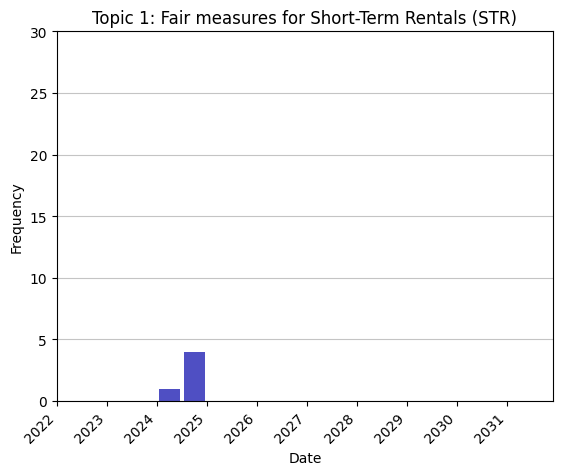

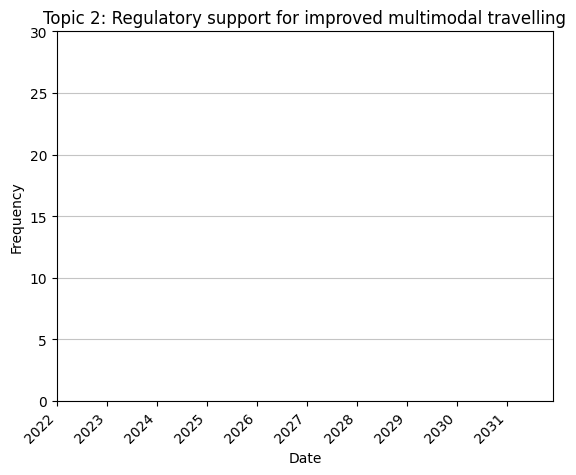

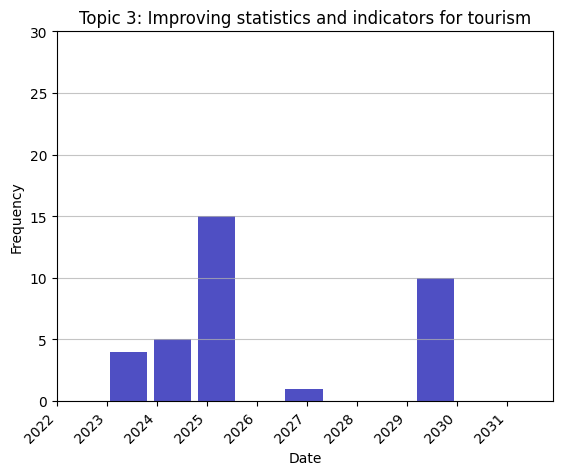

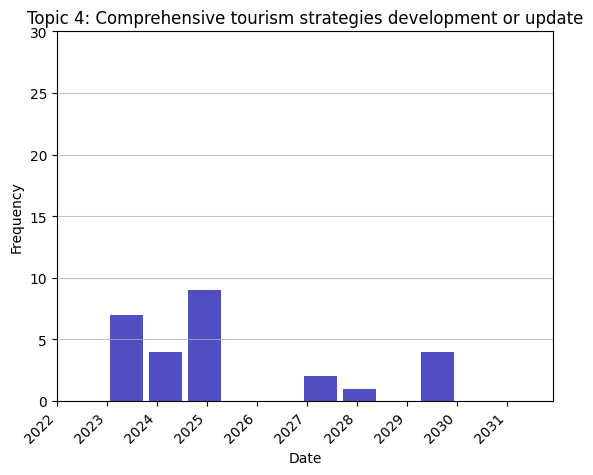

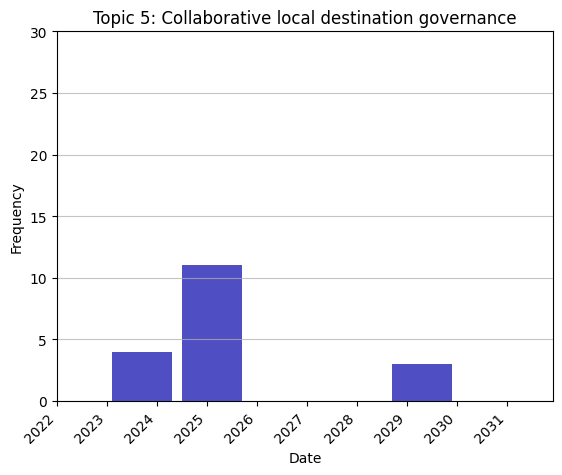

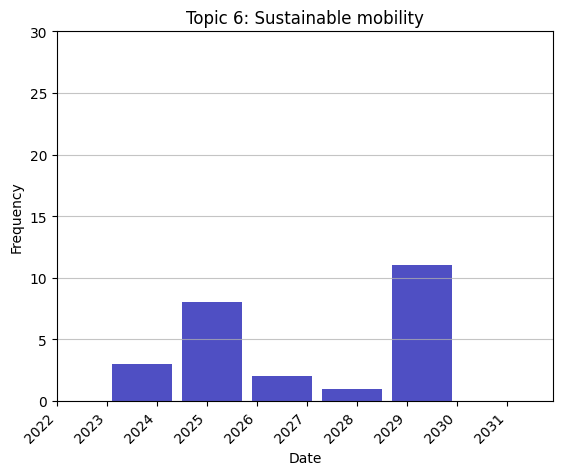

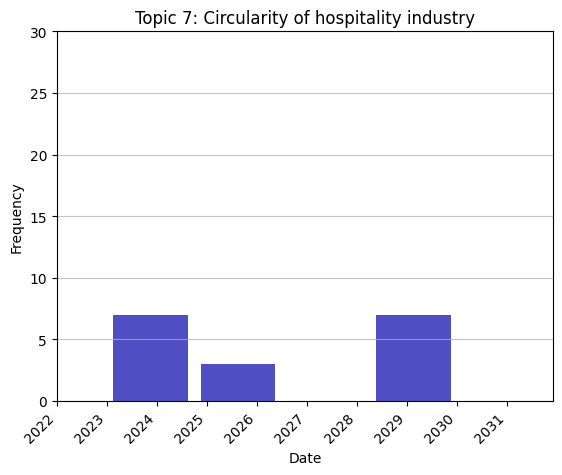

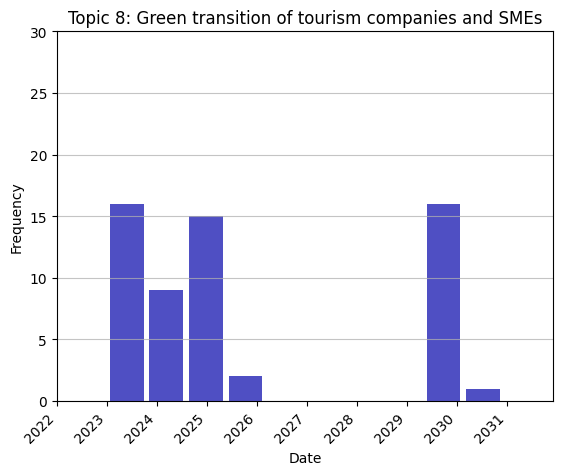

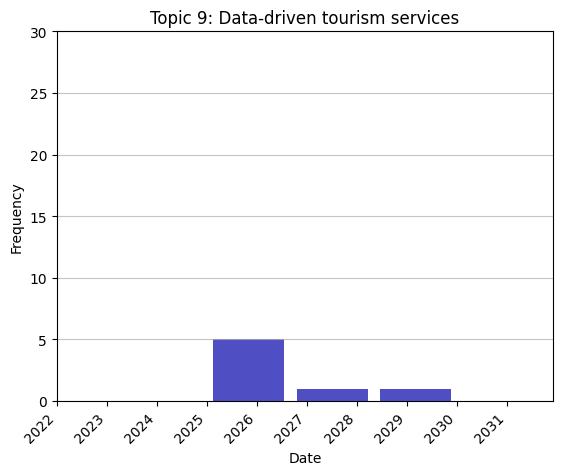

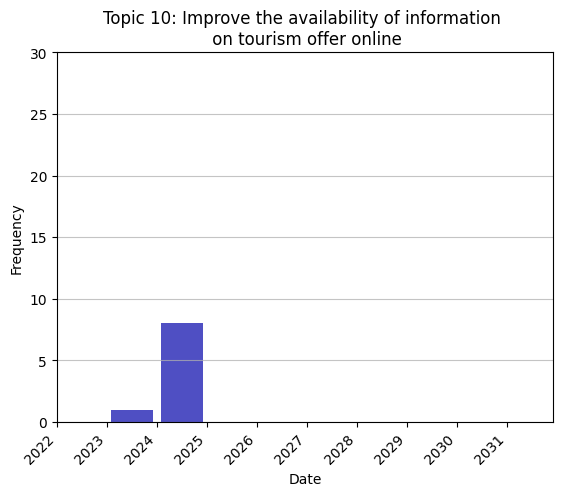

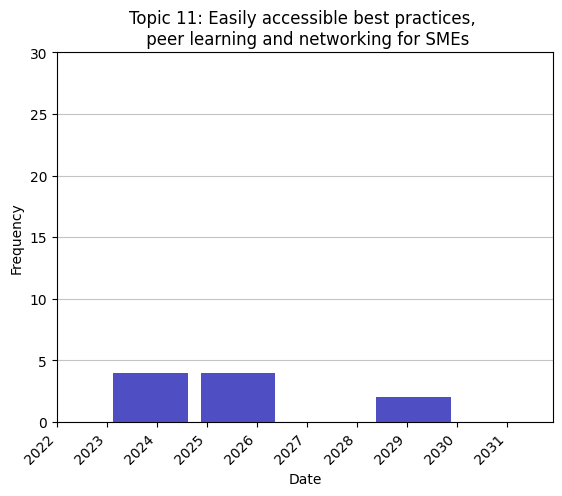

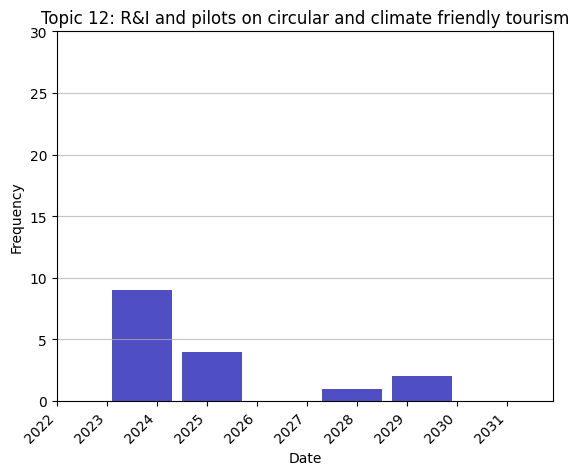

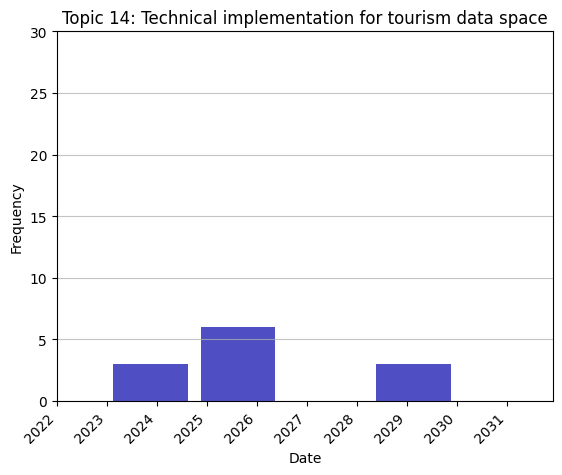

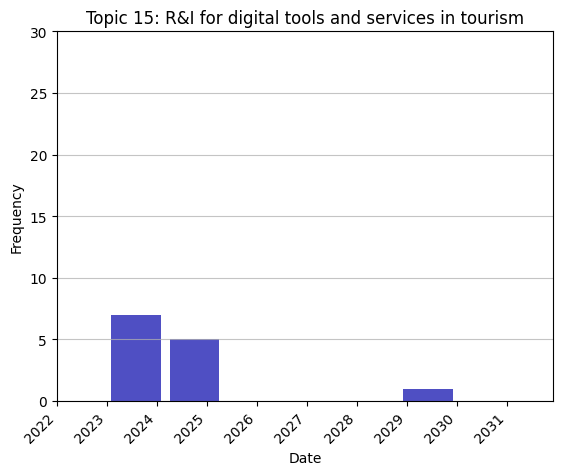

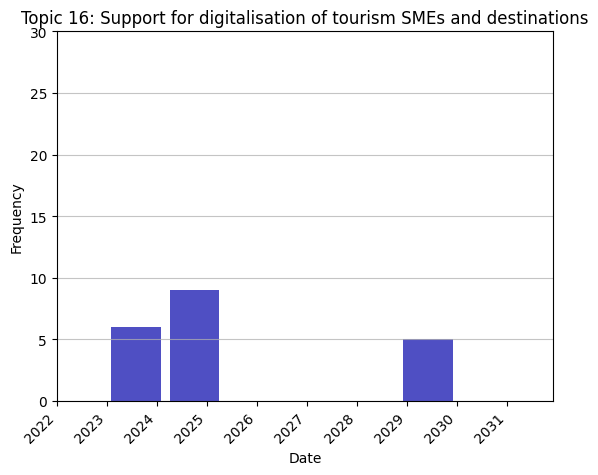

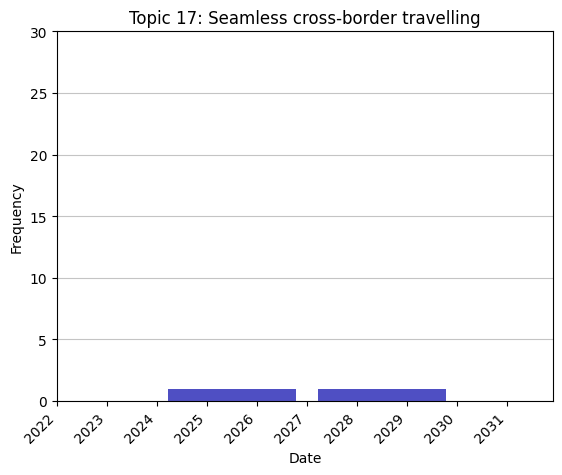

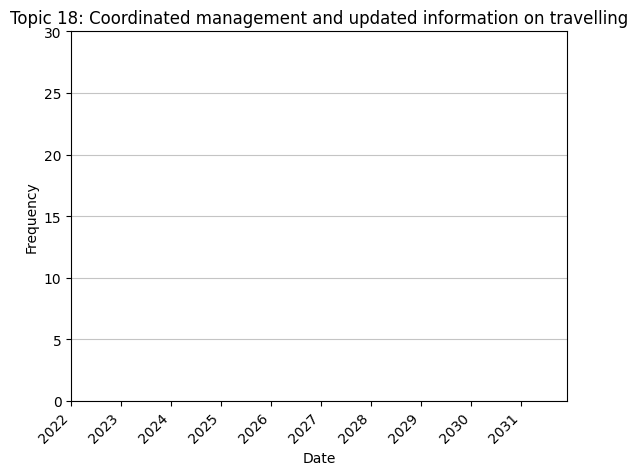

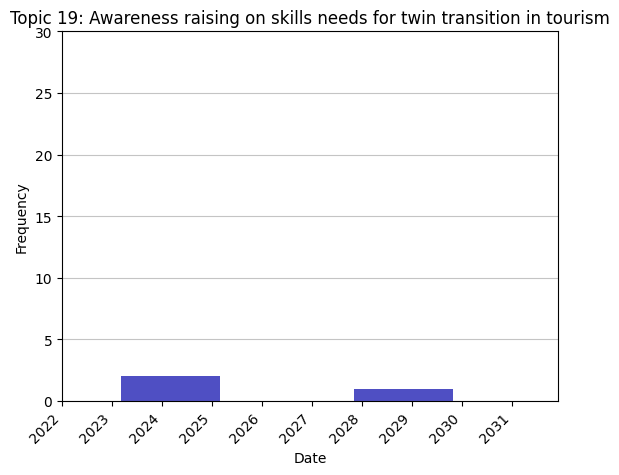

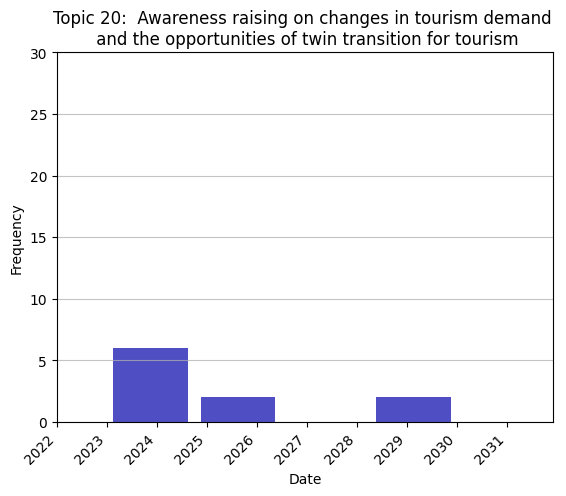

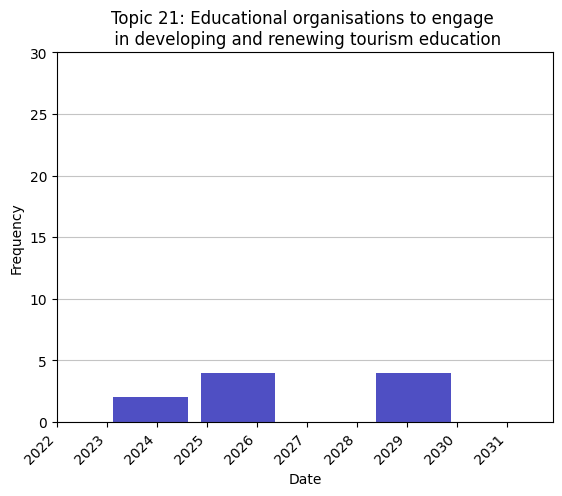

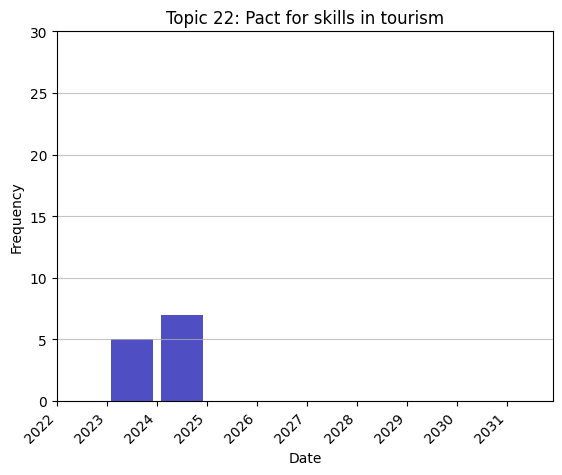

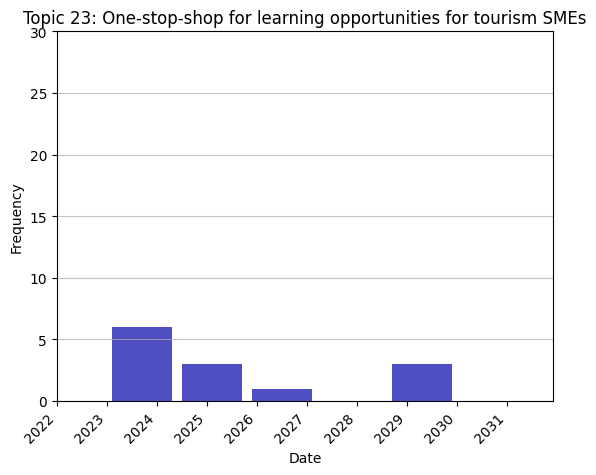

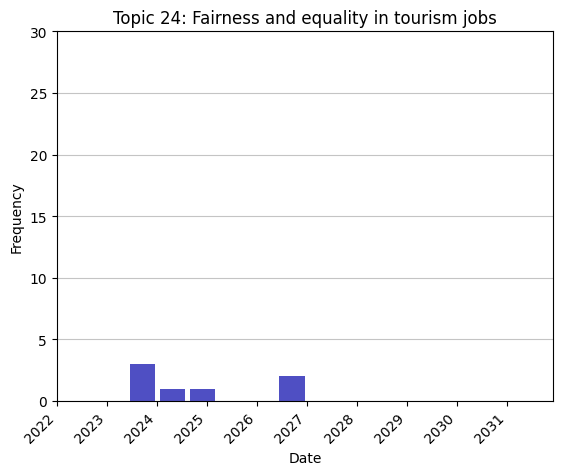

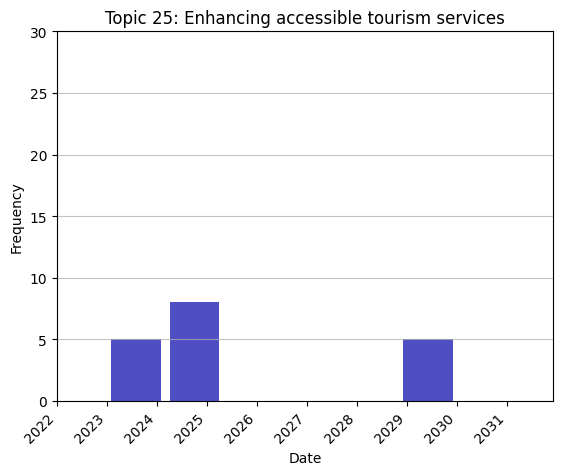

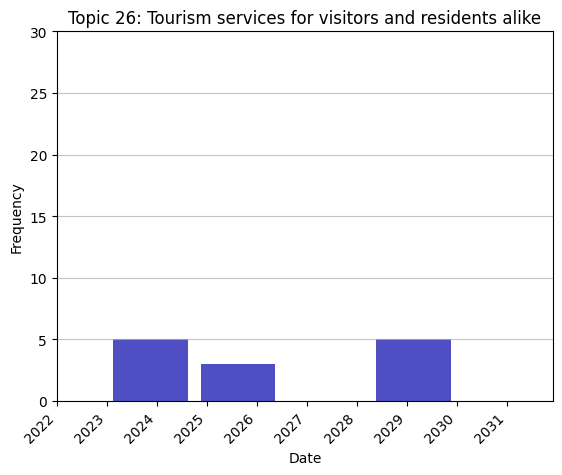

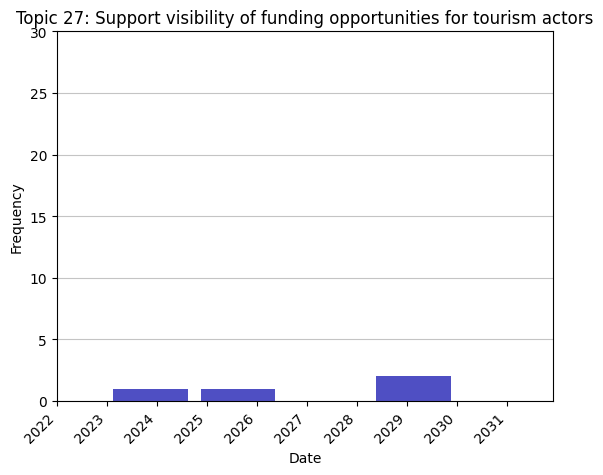

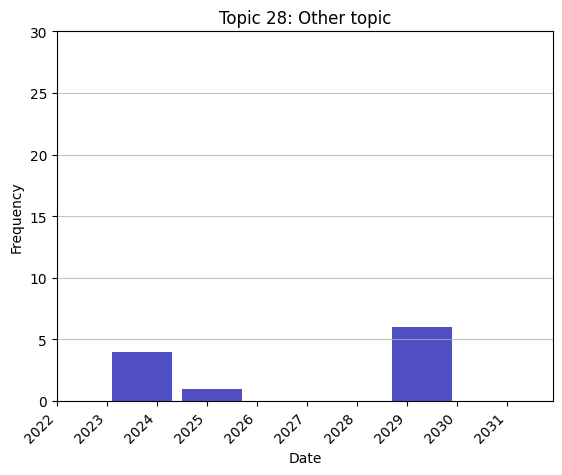

""


In [149]:
import matplotlib.pyplot as plt

def histo(data, name):

    #mapping = {"1": "Data", "2": "Digital", "3": "Sustainable Strategy", "4": "Education & Cooperation", "5": "Sustainable Mobility", "6": "Investment & Start-ups"}
    mapping = {"1": "Fair measures for Short-Term Rentals (STR)", "2": "Regulatory support for improved multimodal travelling", "3": "Improving statistics and indicators for tourism", "4": "Comprehensive tourism strategies development or update", "5": "Collaborative local destination governance", "6": "Sustainable mobility", "7": "Circularity of hospitality industry", "8": "Green transition of tourism companies and SMEs", "9": "Data-driven tourism services", "10": "Improve the availability of information \n on tourism offer online", "11": "Easily accessible best practices, \n peer learning and networking for SMEs", "12": "R&I and pilots on circular and climate friendly tourism", "13": "Appropriation of PEF and OEF methodology \n and development of support tools for tourism ecosystem", "14": "Technical implementation for tourism data space", "15": "R&I for digital tools and services in tourism", "16": "Support for digitalisation of tourism SMEs and destinations", "17": "Seamless cross-border travelling", "18": "Coordinated management and updated information on travelling", "19": "Awareness raising on skills needs for twin transition in tourism", "20": " Awareness raising on changes in tourism demand \n and the opportunities of twin transition for tourism", "21": "Educational organisations to engage \n in developing and renewing tourism education", "22": "Pact for skills in tourism", "23": "One-stop-shop for learning opportunities for tourism SMEs", "24":"Fairness and equality in tourism jobs", "25": "Enhancing accessible tourism services", "26": "Tourism services for visitors and residents alike", "27": "Support visibility of funding opportunities for tourism actors", "28": "Other topic"}
    n = data.groupby("Dates").size()

    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x=data["Dates"], bins=n.size, color='#0504aa',
                                alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.title('Topic ' + str(name[0]) + ': ' + mapping[str(name[0])])
    #maxfreq = n.max()
    plt.xticks(rotation = 45, ha = 'right')
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=30)
    plt.xlim([dateMin, dateMax])
    plt.show()

dateMin = datetime.strptime("January 2022", '%B %Y')
dateMax = datetime.strptime("December 2031", '%B %Y')

data = DatesResults2[(DatesResults2["Dates"] >= dateMin) & (DatesResults2["Dates"] <= dateMax) & (DatesResults2["Results?"] == 1)]

data.groupby('Topics').apply(lambda x: histo(x, x["Topics"].unique()))

In [84]:
# Most frequent words
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

def wordcloud(data):

    cloud=WordCloud(colormap="ocean_r",width=600,height=400, background_color="#c4c2c2", max_words=20, stopwords=stopwords.words("english")).generate(data["Sentences"].str.cat(sep=' ')) # Setting color for the map, background + defining dimensions
    fig=plt.figure(figsize=(13,18)) # Size of the figure
    plt.axis("off") # Removing the axis
    plt.imshow(cloud,interpolation='bilinear')
    plt.show()


#DatesResults[DatesResults["Dates"] > 2025].groupby('Clusters').apply(lambda x: wordcloud(x))

## Dealing with multiple dates sentences

In [20]:
# Outputing sentence with more than 1 date for analysis

len(MultDatesSent)

MultDatesDf = pd.DataFrame(MultDatesSent, columns=["Sentence"])
MultDatesDf.to_excel("NER3.xlsx")

In [ ]:
# Dependency analysis

from spacy import displacy

for sent in MultDatesSent:

    print(sent)
    print("----------------------------------------")

    doc = nlp(sent)

    print(f"{'Node (from)-->':<15} {'Relation':^10} {'-->Node (to)':>15}\n")
    for token in doc:
        print("{:<15} {:^10} {:>15}".format(str(token.head.text), str(token.dep_), str(token.text)))
    displacy.render(doc, style='dep')


In [22]:
# Noun and verb phrases

for sent in MultDatesSent:

    print(sent)
    print("----------------------------------------")

    doc = nlp(sent)

    for chunk in doc.noun_chunks:
        print(chunk)

    print("----------------------------------------")

EFFAT will - in 2023-2024, follow the legislative procedure for the Regulation through European Parliament and Council of Ministers - during this legislative procedure, regularly keep its national member organisations updated about the legislation in the making, by reporting at least 2 times per year on the progress made and agree on measures to be taken by EFFAT and national affiliates - once the Regulation is finally adopted, ask national member organisations to monitor the transposition of the Regulation in their countries and to push for its proper implementation, and to report at least 2 times per year about the actions taken and the progress made - follow the work of the Single Digital Entry Points Coordination Group composed of Member States' national coordinators - continue to address the issue of short-term accommodation rental services in the Sectoral Social Dialogue Committee Horeca, by putting it on the agenda of the 2 Working Group and 1 Plenary meetings per year, and to u

In [165]:
import textacy

for sent in DatesSent:

    print(sent)
    print("----------------------------------------")

    #patterns = [{"POS": "AUX"}, {"POS": "VERB"}]
    patterns = [{'POS': 'VERB', 'OP': '?'},
           {'POS': 'ADV', 'OP': '*'},
           {'POS': 'VERB', 'OP': '+'}]
    about_talk_doc = textacy.make_spacy_doc(
    sent, lang="en_core_web_sm")

    verb_phrase = textacy.extract.token_matches(about_talk_doc, patterns=patterns)

    chunklist = []
    for chunk in verb_phrase:
        print(chunk.text)
        chunklist.append(chunk.text)

    print("----------------------------------------")

Our target for 2025 is to achieve that guideline.
----------------------------------------
achieve
----------------------------------------
EFFAT will - in 2023-2024, follow the legislative procedure for the Regulation through European Parliament and Council of Ministers - during this legislative procedure, regularly keep its national member organisations updated about the legislation in the making, by reporting at least 2 times per year on the progress made and agree on measures to be taken by EFFAT and national affiliates - once the Regulation is finally adopted, ask national member organisations to monitor the transposition of the Regulation in their countries and to push for its proper implementation, and to report at least 2 times per year about the actions taken and the progress made - follow the work of the Single Digital Entry Points Coordination Group composed of Member States' national coordinators - continue to address the issue of short-term accommodation rental services in

In [18]:
import stanza

nlp2 = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency')

2023-04-25 09:48:11 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-04-25 09:48:12 INFO: Loading these models for language: en (English):
| Processor    | Package  |
---------------------------
| tokenize     | combined |
| pos          | combined |
| constituency | wsj      |

2023-04-25 09:48:12 INFO: Using device: cpu
2023-04-25 09:48:12 INFO: Loading: tokenize
2023-04-25 09:48:12 INFO: Loading: pos
2023-04-25 09:48:13 INFO: Loading: constituency
2023-04-25 09:48:13 INFO: Done loading processors!


In [70]:
#stanza.install_corenlp()

2023-04-21 13:56:15 WARNING: Directory C:\Users\ecaudron001\stanza_corenlp already exists. Please install CoreNLP to a new directory.


In [16]:
import re

import nltk


def get_verb_phrases(t):
    verb_phrases = []
    num_children = len(t)
    num_VP = sum(1 if t[i].label() == "VP" else 0 for i in range(0, num_children))

    if t.label() != "VP":
        for i in range(0, num_children):
            if t[i].height() > 2:
                verb_phrases.extend(get_verb_phrases(t[i]))
    elif t.label() == "VP" and num_VP > 1:
        for i in range(0, num_children):
            if t[i].label() == "VP":
                if t[i].height() > 2:
                    verb_phrases.extend(get_verb_phrases(t[i]))
    else:
        verb_phrases.append(' '.join(t.leaves()))

    return verb_phrases


def get_pos(t):
    vp_pos = []
    sub_conj_pos = []
    num_children = len(t)
    children = [t[i].label() for i in range(0, num_children)]

    flag = re.search(r"(S|SBAR|SBARQ|SINV|SQ)", ' '.join(children))

    if "VP" in children and not flag:
        for i in range(0, num_children):
            if t[i].label() == "VP":
                vp_pos.append(t[i].treeposition())
    elif not "VP" in children and not flag:
        for i in range(0, num_children):
            if t[i].height() > 2:
                temp1, temp2 = get_pos(t[i])
                vp_pos.extend(temp1)
                sub_conj_pos.extend(temp2)
    # comment this "else" part, if want to include subordinating conjunctions
    else:
        for i in range(0, num_children):
            if t[i].label() in ["S", "SBAR", "SBARQ", "SINV", "SQ"]:
                temp1, temp2 = get_pos(t[i])
                vp_pos.extend(temp1)
                sub_conj_pos.extend(temp2)
            else:
                sub_conj_pos.append(t[i].treeposition())

    return (vp_pos, sub_conj_pos)


def print_clauses(parse_str):
    sent_tree = nltk.tree.ParentedTree.fromstring(parse_str)
    clause_level_list = ["S", "SBAR", "SBARQ", "SINV", "SQ"]
    clause_list = []
    sub_trees = []
    # sent_tree.pretty_print()

    # break the tree into subtrees of clauses using
    # clause levels "S","SBAR","SBARQ","SINV","SQ"
    for sub_tree in reversed(list(sent_tree.subtrees())):
        if sub_tree.label() in clause_level_list:
            if sub_tree.parent().label() in clause_level_list:
                continue

            if (len(sub_tree) == 1 and sub_tree.label() == "S" and sub_tree[0].label() == "VP"
                    and not sub_tree.parent().label() in clause_level_list):
                continue

            sub_trees.append(sub_tree)
            del sent_tree[sub_tree.treeposition()]

    # for each clause level subtree, extract relevant simple sentence
    for t in sub_trees:
        # get verb phrases from the new modified tree
        verb_phrases = get_verb_phrases(t)

        # get tree without verb phrases (mainly subject)
        # remove subordinating conjunctions
        vp_pos, sub_conj_pos = get_pos(t)
        for i in reversed(vp_pos):
            del t[i]
        for i in reversed(sub_conj_pos):
            del t[i]

        subject_phrase = ' '.join(t.leaves())

        # update the clause_list
        for i in verb_phrases:
            clause_list.append(subject_phrase + " " + i)

    print(clause_list)
    return clause_list

In [21]:
sent = DatesResults["Sentences"].iloc[1]
doc = nlp2(sent)

for sentence in doc.sentences:

    print(sentence.text)
    print("\n")

EFFAT will - in 2023-2024, follow the legislative procedure for the Regulation through European Parliament and Council of Ministers - during this legislative procedure, regularly keep its national member organisations updated about the legislation in the making, by reporting at least 2 times per year on the progress made and agree on measures to be taken by EFFAT and national affiliates - once the Regulation is finally adopted, ask national member organisations to monitor the transposition of the Regulation in their countries and to push for its proper implementation, and to report at least 2 times per year about the actions taken and the progress made - follow the work of the Single Digital Entry Points Coordination Group composed of Member States' national coordinators - continue to address the issue of short-term accommodation rental services in the Sectoral Social Dialogue Committee Horeca, by putting it on the agenda of the 2 Working Group and 1 Plenary meetings per year, and to u

In [28]:
tree = sentence.constituency

tree.children[0].children

((NP (NP (DT The) (NNS actions)) (VP (VBN described) (ADVP (RB above)))),
 (VP (MD shall) (VP (VB contribute) (PP (IN to) (S (VP (VBG achieving) (NP (DT the) (NN aim) (SBAR (IN that) (S (NP (DT all) (NML (JJ short) (HYPH -) (NN term)) (NML (NN accommodation) (NN rental)) (NNS platforms)) (VP (VBP have) (VP (VBN applied) (NP (NP (DT the) (NNS obligations)) (PP (IN of) (NP (DT the) (NN Regulation)))) (PP (PP (IN by) (NP (CD 2025))) (, ,) (CC or) (PP (NP (QP (ADVP (IN at) (JJS least)) (CD 2)) (NNS years)) (IN after) (S (NP (PRP$ its)) (VP (VBG coming) (PP (IN into) (NP (NN force))))))))))))))))),
 (. .))

In [17]:
from nltk import Tree

for sent in DatesResults["Sentences"]:

    print(sent)
    print("----------------------------------------")
    doc = nlp2(sent)

    for sentence in doc.sentences:
        parse_str = str(sentence.constituency)
        
        print_clauses(parse_str)

    print("----------------------------------------")


Our target for 2025 is to achieve that guideline.
----------------------------------------
['Our target for 2025 . is to achieve that guideline']
----------------------------------------
EFFAT will - in 2023-2024, follow the legislative procedure for the Regulation through European Parliament and Council of Ministers - during this legislative procedure, regularly keep its national member organisations updated about the legislation in the making, by reporting at least 2 times per year on the progress made and agree on measures to be taken by EFFAT and national affiliates - once the Regulation is finally adopted, ask national member organisations to monitor the transposition of the Regulation in their countries and to push for its proper implementation, and to report at least 2 times per year about the actions taken and the progress made - follow the work of the Single Digital Entry Points Coordination Group composed of Member States' national coordinators - continue to address the issue

In [19]:
len(DatesSent)

455

In [20]:
DatesPledge.count(0)

66

In [90]:
PledgeDf.to_excel("NER_2.xlsx")

In [17]:
nlp = spacy.load("en_core_web_sm")

sentence = PledgeDf["Pledge"].iloc[285]

doc = nlp(sentence)

displacy.render(doc, style = "ent", jupyter = True)

In [42]:
from nltk.tokenize import sent_tokenize, TabTokenizer

DatesSentDf = pd.DataFrame()
DatesSent = []
Topic = []

for i in range(272): 
    sentence = PledgeDf["Pledge"].iloc[i]

    doc = nlp(sentence)

    datesPattern = re.compile(r'(\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3})')
    dates = set((ent.text) for ent in doc.ents if ent.label_ == "DATE")
    filteredDates = set(date for date in dates if not datesPattern.match(date))

    for sent in doc.sents:

        if any(date in sent.text for date in filteredDates): 

            #print(sent)
            Topic.append(PledgeDf["Topic"].iloc[i])
            DatesSent.append(sent.text)


            # if any(ele in sent.text for ele in resultWords): 
            #     print(sent)





In [31]:
len(DatesSent)

478

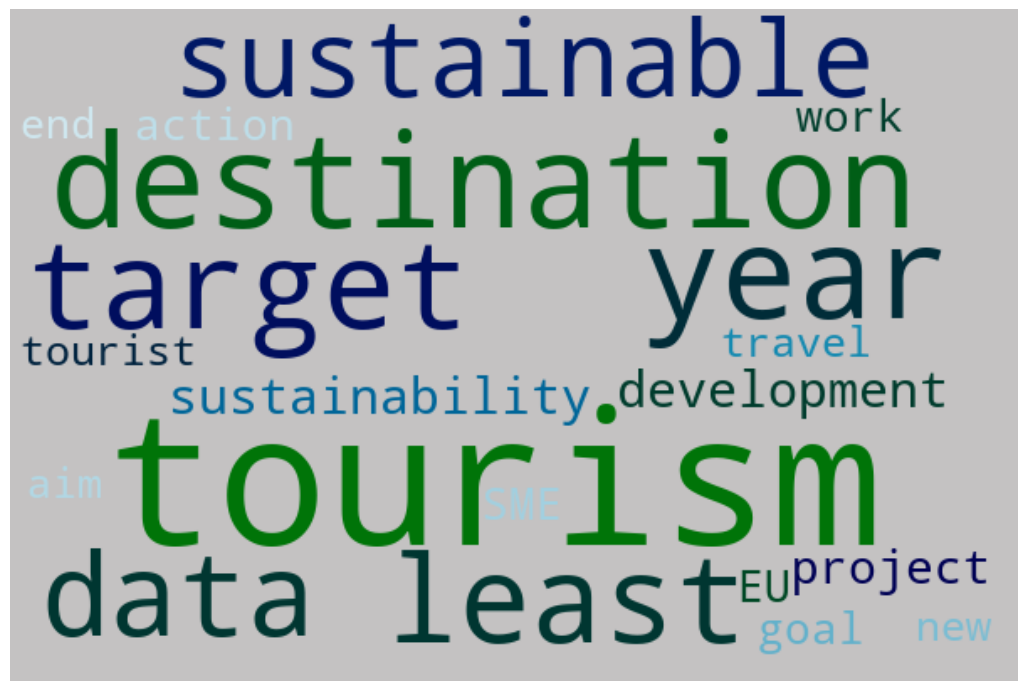

In [43]:
# Most frequent words
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

def wordcloud(data):

    cloud=WordCloud(colormap="ocean_r",width=600,height=400, background_color="#c4c2c2", max_words=20, stopwords=stopwords.words("english")).generate(data["PreProcessedText"].str.cat(sep=' ')) # Setting color for the map, background + defining dimensions
    fig=plt.figure(figsize=(13,18)) # Size of the figure
    plt.axis("off") # Removing the axis
    plt.imshow(cloud,interpolation='bilinear')
    plt.show()

DatesSentDf["PreProcessedText"] = DatesSent 
DatesSentDf["Topic"] = Topic
wordcloud(DatesSentDf)


In [45]:
resultWords = ["As a target for", "by", "prepare", "aim", "action", "results", "result", "target", "targets"]

ResultsSent = []
Dates = []
Topic = []
ResultsDf = pd.DataFrame()

DatesSentDf = PledgeDf[PledgeDf["Dates ?"] == 1]

for sent, topic, date in zip(DatesSentDf["PreProcessedText"], DatesSentDf["Topic"], DatesSentDf["Date"]):

    if any(ele in sent for ele in resultWords): 
        
        doc = nlp(sent)

        datesPattern = re.compile(r'(\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3})')
        dates = set((ent.text) for ent in doc.ents if ent.label_ == "DATE")
        filteredDates = set(date for date in dates if not datesPattern.match(date))

        for date in filteredDates:

            Dates.append(date)
            ResultsSent.append(sent)
            Topic.append(topic)

ResultsDf["Sentence"] = ResultsSent
ResultsDf["Dates"] = Dates
ResultsDf["Topic"] =Topic


In [46]:
ResultsDf

,Sentence,Dates,Topic
0,Our target for 2025 is to achieve that guideli...,2025,1
1,The actions described above shall contribute t...,2025,1
2,The actions described above shall contribute t...,at least 2 years,1
3,Our target for 2025 is to have at least 15 pro...,2025,1
4,"Furthermore, many holiday properties stand emp...",the year,1
...,...,...,...
275,Our organization commits to:\r\n\r\nExternal:\...,2225,16
276,"Keep updated on the ""Visit Värmland’s Toolbox ...",three months,16
277,Traveler ID is already used by many airlines a...,2030,17
278,We expect to have this system implemented by 2...,2025,18


In [47]:
ResultsDf.to_excel("NER.xlsx")

# NER with ctparse

In [13]:
from ctparse import ctparse
from datetime import datetime

In [20]:
ts = datetime(2023, 4,17,9,42)
ctparse("the year", ts = ts)

CTParse(2023-12-31 X:X (X/X), (119, 'ruleEOY'), -977.9325646617849)